In [382]:
using Plots, LinearAlgebra

---

# "Almost" Zero-Allocation Neural Network

In [383]:
module ZeroAllocationNN
using LinearAlgebra
export ZANN
mutable struct ZANN{T<:AbstractFloat}
    weights :: Vector{Matrix{T}}
    biases :: Vector{Vector{T}}
    
    weighted_inputs :: Vector{Matrix{T}}
    activations :: Vector{Matrix{T}}
        
    nabla_ws :: Vector{Matrix{T}}
    nabla_bs :: Vector{Vector{T}}
    
    function ZANN(::Type{T}, layer_dims) where {T<:AbstractFloat}
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(T, layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(T, layer_dims[i]))
        end
        return new{T}(
            weights,
            biases,
            Vector{Matrix{T}}(undef, length(layer_dims) - 1),
            Vector{Matrix{T}}(undef, length(layer_dims)),
            Vector{Matrix{T}}(undef, length(layer_dims) - 1),
            Vector{Vector{T}}(undef, length(layer_dims) - 1)
        )
    end
end

sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export predict
function predict(nn::ZANN{T}, x :: Matrix{T}) where {T}
    a = x
    for (w, b) in zip(nn.weights, nn.biases)
        a = sigma.(w * a .+ b) # .+ to repeat b along axis 1 (the minibatch size axis)
    end
    return a
end

@views function nabla_ws_from_delta_activations!(nabla_ws :: Array{T, 2}, delta :: Matrix{T}, a :: Matrix{T}) where T<:AbstractFloat
    size(delta, 2) == size(a, 2) || throw(DimensionMismatch("size(A, 2) must equal size(B, 2), found $(size(delta, 2)) and $(size(nn.activations[end-1], 2)) instead"))
    
    tmp = delta[:,1]* a[:,1]' # preallocate
    for i in 1:size(delta, 2)
        @inbounds mul!(tmp, delta[:,i], a[:,i]')
        @. nabla_ws[:,:] += tmp
    end
end

export backprop
function backprop(nn::ZANN{T}, x :: Matrix{T}, y :: Matrix{T}) where {T}
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    nn.activations[1] = x

    for (i, (w, b)) in enumerate(zip(nn.weights, nn.biases))
        nn.weighted_inputs[i] = w * nn.activations[i]
        @. nn.weighted_inputs[i] += b
        nn.activations[i+1] = sigma.(nn.weighted_inputs[i])
    end

    # backward pass
    # BP1 (Output layer error)
    delta :: Matrix{T} = (nn.activations[end] - y) .* sigma_prime.(nn.weighted_inputs[end])

    # BP3 (Cost gradient w.r.t Bias)
    nn.nabla_bs[1] = sum(delta,dims=2)[:,1]

    # BP4 (Cost gradient w.r.t weights)
    tmp = zeros(T, size(delta, 1), size(nn.activations[end-1], 1))
    nabla_ws_from_delta_activations!(tmp, delta, nn.activations[end-1])
    nn.nabla_ws[1] = tmp
    
    for (i, (w, z, a)) in enumerate(Iterators.reverse(zip(
                    nn.weights, nn.weighted_inputs[1:end-1], nn.activations[1:end-2])))
        # BP2 (Previous layer error)
        delta = (w'*delta)
        @. delta *= sigma_prime(z)
        
        nn.nabla_bs[i+1] = sum(delta, dims=2)[:, 1]
        
        tmp = zeros(T, size(delta, 1), size(a, 1))
        nabla_ws_from_delta_activations!(tmp, delta, a)
        nn.nabla_ws[i+1] = tmp
    end
    
    return reverse(nn.nabla_ws), reverse(nn.nabla_bs)
end
end

import Main.ZeroAllocationNN
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float64, [784,100,20,1]);

println("Prediction (expected allocations: $((Base.summarysize(randn(784,100)) + Base.summarysize(randn(100,100)) + Base.summarysize(randn(20,100)) + Base.summarysize(randn(1,100)))/1000))")
ZeroAllocationNN.predict(zann, prepared_mnist_x[:, 1:100])
@time ZeroAllocationNN.predict(zann, prepared_mnist_x[:, 1:100])

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, prepared_mnist_x[:, 1:100], prepared_mnist_y[:, 1:100]);
@time ZeroAllocationNN.backprop(zann, prepared_mnist_x[:, 1:100], prepared_mnist_y[:, 1:100]);

Network creation 


  0.000389 seconds (19 allocations: 630.844 KiB)
Prediction (expected allocations: 724.16)
  0.000633 seconds (12 allocations: 802.297 KiB)
Backpropagation 
  0.016110 seconds (51 allocations: 2.109 MiB)


---

# XOR (Useful for testing)

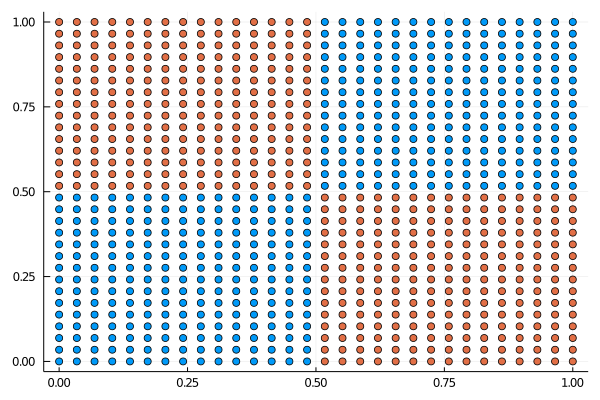

In [384]:
# One-hot encoding
# [1,0] represents xor = 0
# [0,1] represents xor = 1
to_xor_onehot(x1, x2) = ifelse((round(Int, x1) ⊻ round(Int, x2)) == 0, [1f0;0f0], [0f0;1f0]) 
domain = range(0f0, stop=1f0, length=30)
dataset = vec([([x1, x2], to_xor_onehot(x1, x2)) for x1 in domain, x2 in domain])
scatter(map(x->x[1][1], dataset), map(x->x[1][2], dataset), color=map(x -> ifelse(x[2] == [1f0;0f0], 1, 2), dataset), legend=false)

In [385]:
prepared_dataset_x = hcat(map(x->Float32.(x[1]), dataset)...)
prepared_dataset_y = hcat(map(x->Float32.(x[2]), dataset)...)

println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float32, [2,40,2,2]);

println("Prediction ")
ZeroAllocationNN.predict(zann, prepared_dataset_x)
@time ZeroAllocationNN.predict(zann, prepared_dataset_x)

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);
@time ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);

Network creation 
  0.000023 seconds (18 allocations: 2.375 KiB)
Prediction 
  0.000649 seconds (8 allocations: 310.156 KiB)
Backpropagation 
  0.002213 seconds (42 allocations: 475.688 KiB)


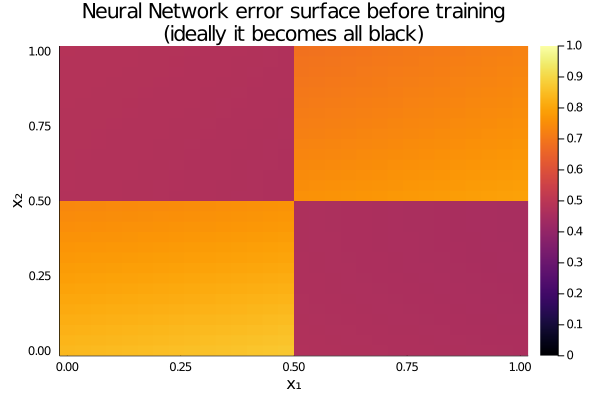

In [386]:
heatmap(
    domain,
    domain,
    (x1, x2) -> sum((ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :)) - to_xor_onehot(x1, x2)).^2),
    title="Neural Network error surface before training\n(ideally it becomes all black)",
    xlabel="x₁",
    ylabel="x₂",
    clims=(0, 1)
)

### STOCHASTIC GRADIENT DESCENT (minibatch_size = 16)

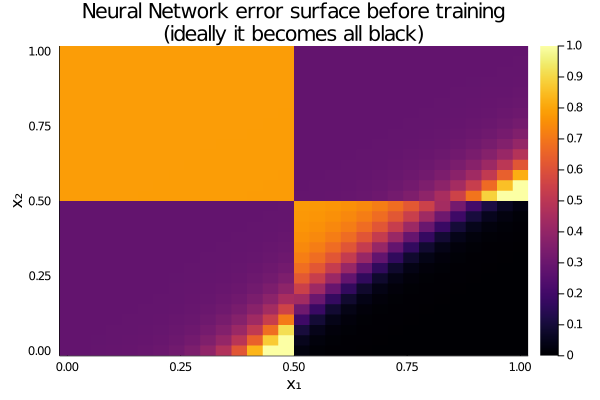

  4.622345 seconds (6.92 M allocations: 1.193 GiB, 5.92% gc time)
  

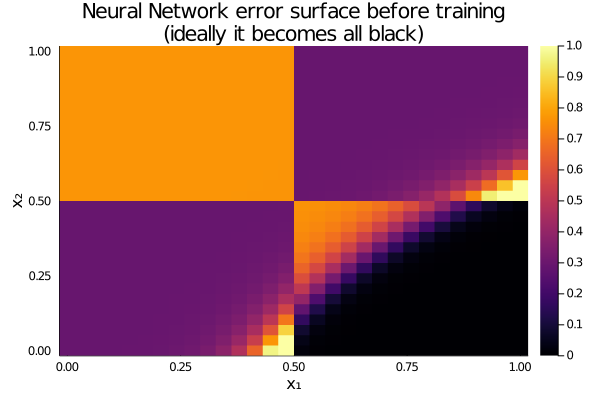

4.448216 seconds (6.81 M allocations: 1.188 GiB, 6.11% gc time)


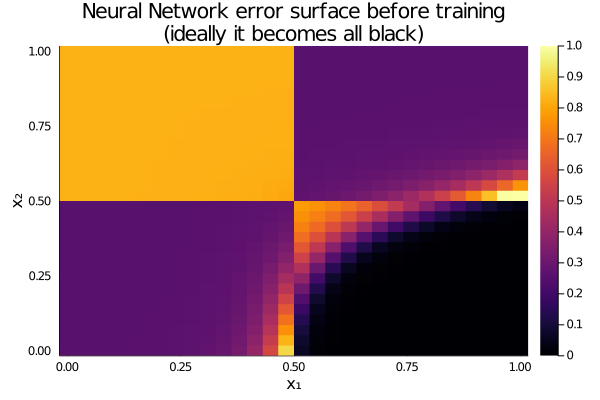

  4.409020 seconds (6.81 M allocations: 1.188 GiB, 6.37% gc time)
  

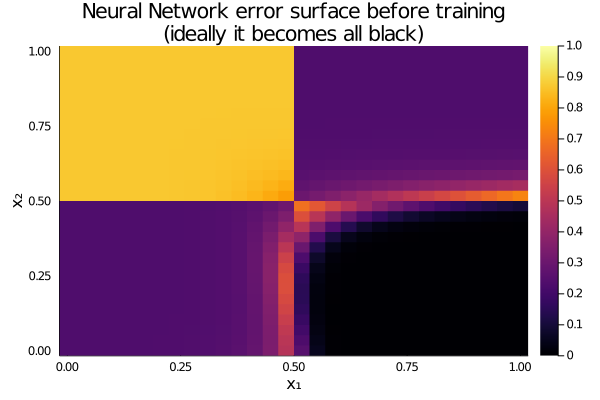

4.395835 seconds (6.81 M allocations: 1.188 GiB, 6.39% gc time)


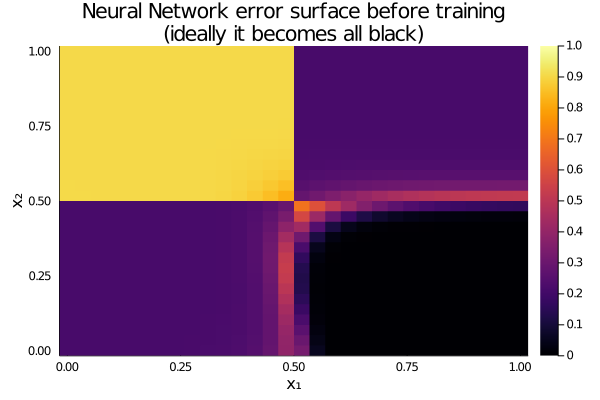

  4.461927 seconds (6.81 M allocations: 1.188 GiB, 6.44% gc time)
  

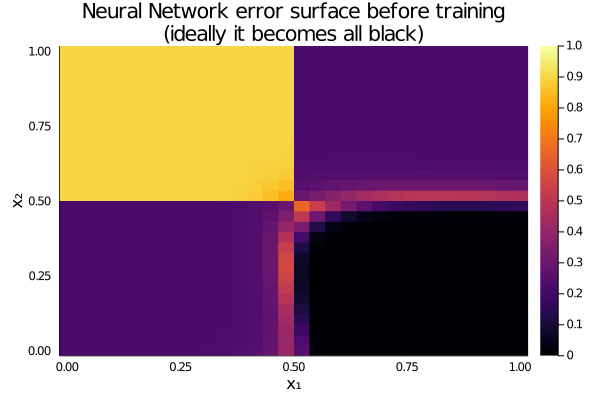

4.352192 seconds (6.81 M allocations: 1.188 GiB, 5.98% gc time)


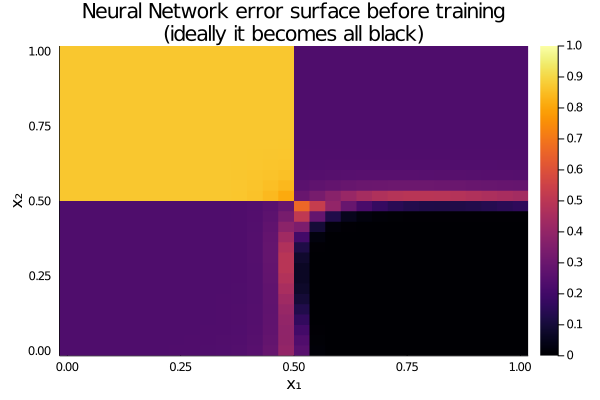

  4.380779 seconds (6.81 M allocations: 1.188 GiB, 6.48% gc time)
  

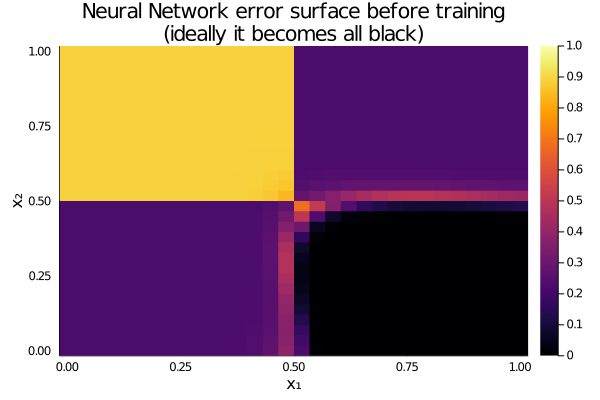

4.389320 seconds (6.81 M allocations: 1.188 GiB, 6.37% gc time)


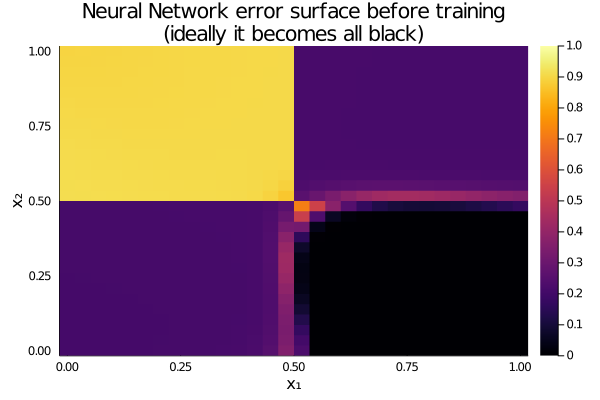

  4.385449 seconds (6.81 M allocations: 1.188 GiB, 6.38% gc time)
  

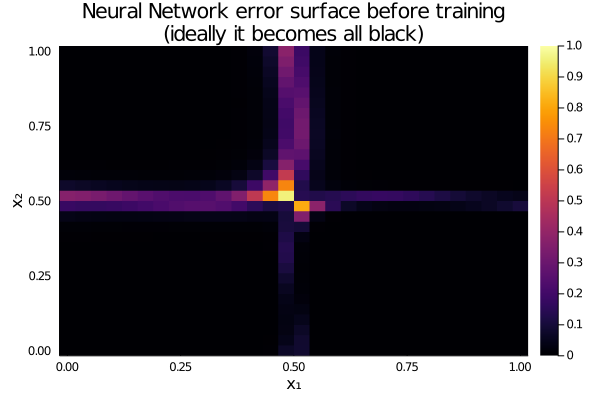

4.373872 seconds (6.81 M allocations: 1.188 GiB, 5.85% gc time)


In [387]:
epochs = 60_000
minibatch_size = 10
eta = 0.05

accuracy = Vector{Float64}()

for _ in 1:10
    @time for epoch in 1:epochs 
        # Obtain minibatch
        minibatch = rand(dataset, minibatch_size)
        x = hcat(map(x->x[1], minibatch)...)
        y = hcat(map(x->Float32.(x[2]), minibatch)...)
        
        # Obtain gradient vectors with backpropagation
        delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

        # Average the gradients of each datum in the minibatch
        nabla_ws = delta_nabla_ws / minibatch_size
        nabla_bs = delta_nabla_bs / minibatch_size

        # Perform gradient descent using the gradients
        zann.weights -= (eta * nabla_ws)
        zann.biases -= (eta * nabla_bs)
        
        # Calculate accuracy
        if epoch % 1000 == 0
            predictions = ZeroAllocationNN.predict(zann, prepared_dataset_x)
            push!(accuracy, sum((prepared_dataset_y - predictions).^2)/length(dataset))
        end
    end

    display(heatmap(
        domain,
        domain,
        (x1, x2) -> sum((ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :)) - to_xor_onehot(x1, x2)).^2),
        title="Neural Network error surface before training\n(ideally it becomes all black)",
        xlabel="x₁",
        ylabel="x₂",
        clims=(0, 1)
    ))
end

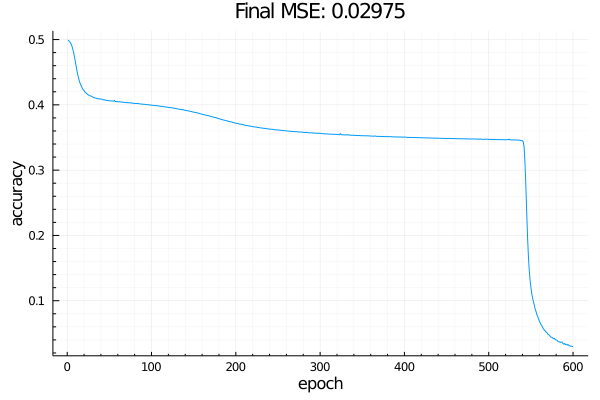

In [388]:
plot(accuracy, xlabel="epoch", ylabel="accuracy", minorgrid=true, minorticks=5, title="Final MSE: $(round(accuracy[end], digits=5))", label=false)

In [390]:
for (x1, x2) in ((0.1f0,0.2f0), (0.9f0,0.8f0), (0.1f0, 0.7f0), (0.9f0, 0.2f0))
    predicted = ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))
    expected = ifelse((round(Int, x1) ⊻ round(Int, x2)) == 0, [1f0;0f0], [0f0;1f0])
    println("($x1, $x2) => $predicted - $expected")
end

(0.1, 0.2) => Float32[0.9803064; 0.020575702] - Float32[1.0, 0.0]
(0.9, 0.8) => Float32[0.980993; 0.019866776] - Float32[1.0, 0.0]
(0.1, 0.7) => Float32[0.021035805; 0.97810477] - Float32[0.0, 1.0]
(0.9, 0.2) => Float32[0.014723944; 0.98428106] - Float32[0.0, 1.0]


---

## MNIST

In [268]:
using MLDatasets

In [269]:
one_or_zero_ixs = findall(x->x==0||x==1, MNIST.trainlabels());

In [270]:
using ImageCore

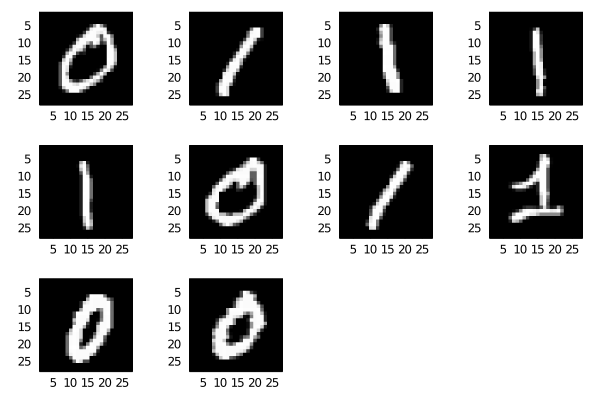

In [271]:
plot([plot(MNIST.convert2image(MNIST.traintensor(one_or_zero_ixs[i]))) for i in 1:10]...)

In [396]:
prepared_mnist_x = reshape(MNIST.traintensor(Float64, one_or_zero_ixs), 784, :)
# 0 => [1.0, 0.0]
# 1 => [0.0, 1.0]
prepared_mnist_y = hcat(map(label -> ifelse(label == 0, [1.0, 0.0], [0.0, 1.0]), MNIST.trainlabels(one_or_zero_ixs))...)

2×12665 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0     1.0  1.0  0.0  1.0  1.0  0.0  1.0

In [399]:
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float64, [784,100,20,2]);

println("Prediction (expected allocations: $(Base.summarysize(randn(784,100)) + Base.summarysize(randn(100,100)) + Base.summarysize(randn(20,100)) + Base.summarysize(randn(1,100))))")
@time ZeroAllocationNN.predict(zann, prepared_mnist_x)

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, prepared_mnist_x, prepared_mnist_y);
@time ZeroAllocationNN.backprop(zann, prepared_mnist_x, prepared_mnist_y);

Network creation 
  0.000453 seconds (19 allocations: 631.000 KiB)
Prediction (expected allocations: 724160)
  0.091089 seconds (12 allocations: 23.577 MiB)
Backpropagation 
  1.704537 seconds (51 allocations: 36.791 MiB, 1.32% gc time)


In [400]:
using TimerOutputs

In [402]:
epochs = 500
minibatch_size = 16
eta = 1e-0

accuracy = Vector{Float64}()

reset_timer!()
@timeit "whole training loop" for epoch in 1:epochs 
    # Obtain minibatch
    minibatch_ixs = rand(1:size(prepared_mnist_y, 2), minibatch_size)
    x = prepared_mnist_x[:, minibatch_ixs]
    y = prepared_mnist_y[:, minibatch_ixs]

    # Obtain gradient vectors with backpropagation
    @timeit "backprop step" delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

    # Average the gradients of each datum in the minibatch
    nabla_ws = delta_nabla_ws / minibatch_size
    nabla_bs = delta_nabla_bs / minibatch_size

    # Perform gradient descent using the gradients
    zann.weights -= (eta * nabla_ws)
    zann.biases -= (eta * nabla_bs)

    # Calculate accuracy
    @timeit "accuracy calculation" if epoch % 50 == 0
        predictions = ZeroAllocationNN.predict(zann, prepared_mnist_x)
        acc = sum((prepared_mnist_y - predictions).^2)/ length(prepared_mnist_y)
        println(acc)
        push!(accuracy, acc)
    end
end
print_timer()


0.26647743559068443
0.04410039390117952
0.02231607328693979
0.014073390524873787
0.010910317403978156
0.009064192382784947
0.007518100163803559
0.006698075051610532
0.006082640849947482
0.005650891512587467
 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            3.23s / 96.4%           1.81GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 whole training loop        1    3.12s   100%   3.12s   1.81GiB  100%   1.81GiB
   backprop step          500    1.86s  59.7%  3.72ms    638MiB  34.5%  1.28MiB
   accuracy calcula...    500    795ms  25.5%  1.59ms    240MiB  13.0%   491KiB
 ───────────────────────────────────────────────────────────────────────

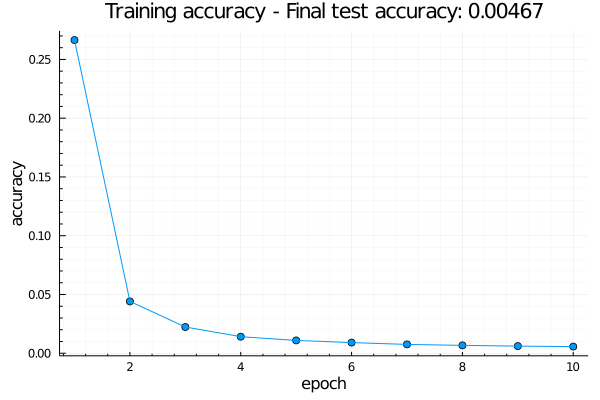

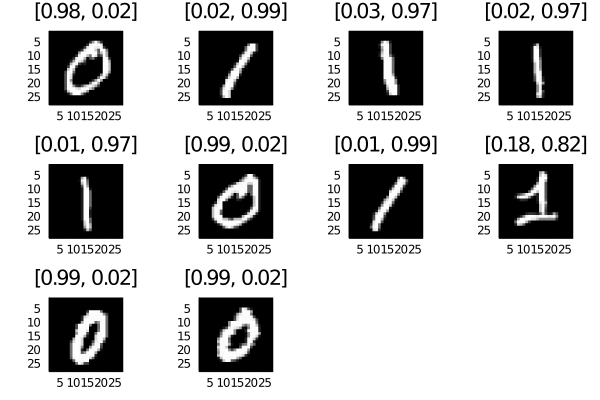

In [405]:
one_or_zero_ixs_test = findall(x->x==0||x==1, MNIST.testlabels());
prepared_mnist_x_test = reshape(MNIST.testtensor(Float64, one_or_zero_ixs_test), 784, :)
prepared_mnist_y_test = hcat(map(label -> ifelse(label == 0, [1.0, 0.0], [0.0, 1.0]), MNIST.testlabels(one_or_zero_ixs_test))...)
predictions = ZeroAllocationNN.predict(zann, prepared_mnist_x_test)

test_accuracy = sum((prepared_mnist_y_test - predictions).^2)/ length(prepared_mnist_y_test)

scatter(
    accuracy,
    title="Training accuracy - Final test accuracy: $(round(test_accuracy, digits=6))",
    label=false,
    xlabel="epoch", ylabel="accuracy", minorgrid=true, minorticks=5,
)
display(plot!(
    accuracy,
    c=1,
    label=false,
))

plot([
        plot(
            MNIST.convert2image(MNIST.traintensor(one_or_zero_ixs[i])),
            title=round.(
                ZeroAllocationNN.predict(zann, prepared_mnist_x[:, [i]]),
                digits=2
            )
        )
        for i in 1:10
    ]...
)